In [527]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
import torch

from matplotlib import cm
from matplotlib.ticker import LinearLocator

from mpl_toolkits.mplot3d import axes3d


In [528]:
# | export


def complex_oscillator_exp(
    z: torch.ComplexType,
    initial_phase: torch.ComplexType = None,
    N: int = 2048,
    constrain: bool = False,
    reduce: bool = False,
):
    """Generates an exponentially decaying sinusoid from a complex number."""

    if initial_phase is None:
        # If no initial phase is provided, use zero phase.
        # Note that in the complex representation, zero phase is equivalent to a real number.
        initial_phase = torch.ones_like(z)
    
    if constrain:
        # Limit the magnitude of z to 1. Note that tanh is used in lieu of sigmoid to 
        # avoid vanishing gradients as magnitude approaches zero.
        mag = torch.abs(z)
        z = z * torch.tanh(mag) / mag

    z = z[..., None].expand(*z.shape, N - 1)
    z = torch.cat([initial_phase.unsqueeze(-1), z], dim=-1)
    
    y = z.cumprod(dim=-1)

    if reduce:
        y = y.sum(dim=-2)

    return y

## Loss visualisation for full sampling

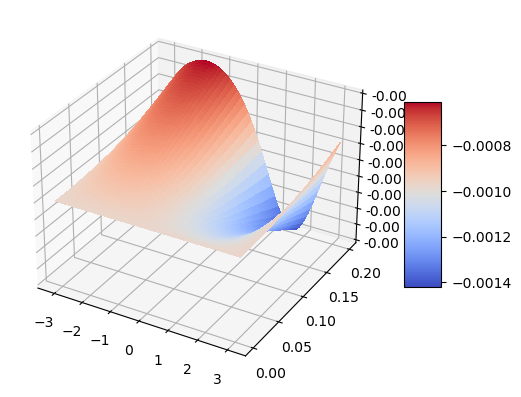

In [529]:
N = 1024
n = np.arange(N)


target_freq = torch.tensor(0.5) * pi

sig = 0
target_signal = torch.exp(1j*target_freq * n) + sig**2/2 * torch.complex(torch.randn(n.shape),torch.randn(n.shape))

criterion = torch.nn.MSELoss()

rrange = torch.linspace(0,0.2,100)
thetarange = torch.linspace(-1,1,100) * pi

mse = torch.zeros((rrange.shape[0],thetarange.shape[0]))

for a in range(rrange.shape[0]):
    for b in range(thetarange.shape[0]):
        predicted_z = rrange[a]*torch.exp(1j * thetarange[b])  #torch.exp(1j * thetarange[i])
        predicted_signal = (complex_oscillator_exp(predicted_z, N=N))
        mse[a,b] = criterion(torch.real(predicted_signal), torch.real(target_signal)) + criterion(torch.imag(predicted_signal), torch.imag(target_signal))-1

X, Y = np.meshgrid(thetarange, rrange)
Z = mse

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()



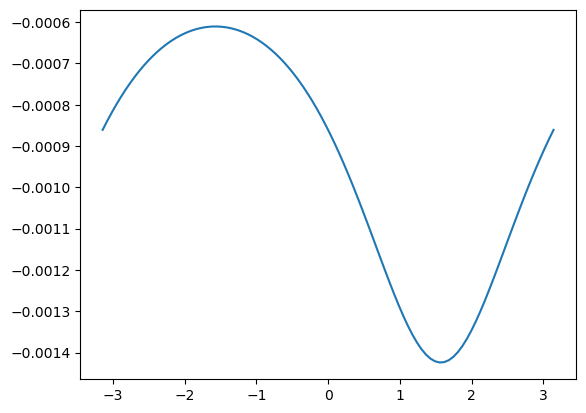

In [530]:
plt.plot(thetarange,mse[-1,:])
plt.show()

## Loss visualisation for random undersampling

torch.float64
torch.float64 torch.float64
torch.Size([1024]) torch.Size([1024])


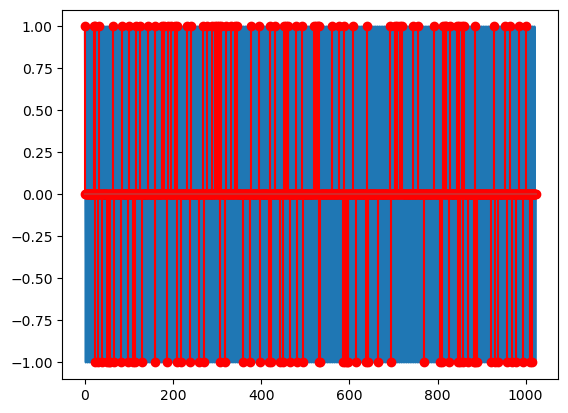

In [531]:
M = 256

idx = np.sort(np.random.choice(np.arange(N),(M,),replace=False))


sampling_vector = torch.zeros((N,),dtype=torch.float64)
print(sampling_vector.dtype)
sampling_vector[idx] = 1

sampling_matrix = torch.diag(sampling_vector)


print(sampling_matrix.dtype,torch.real(target_signal.unsqueeze(1)).dtype)

randomly_sampled_signal = torch.complex(sampling_matrix @ torch.real(target_signal.unsqueeze(1)),sampling_matrix @ torch.imag(target_signal.unsqueeze(1)))

print(randomly_sampled_signal.squeeze().shape,target_signal.shape)
plt.plot(torch.real(target_signal))
plt.stem(torch.real(randomly_sampled_signal.squeeze()),'r')
plt.show()

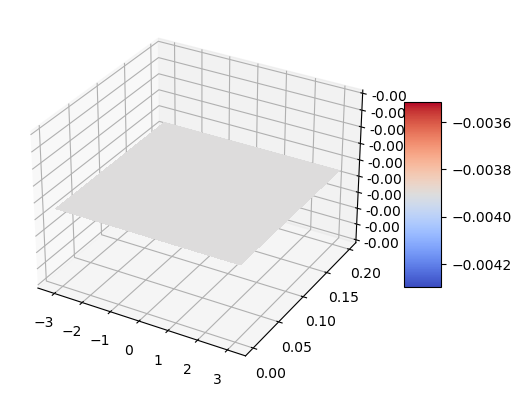

In [532]:
mse = torch.zeros((rrange.shape[0],thetarange.shape[0]))

for a in range(rrange.shape[0]):
    for b in range(thetarange.shape[0]):
        predicted_z = rrange[a]*torch.exp(1j * thetarange[b])  #torch.exp(1j * thetarange[i])
        predicted_signal = (complex_oscillator_exp(predicted_z, N=N))
        mse[a,b] = criterion(torch.real(predicted_signal[idx]), torch.real(target_signal[idx])) + criterion(torch.imag(predicted_signal[idx]), torch.imag(target_signal[idx]))-1

X, Y = np.meshgrid(thetarange, rrange)
Z = mse

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

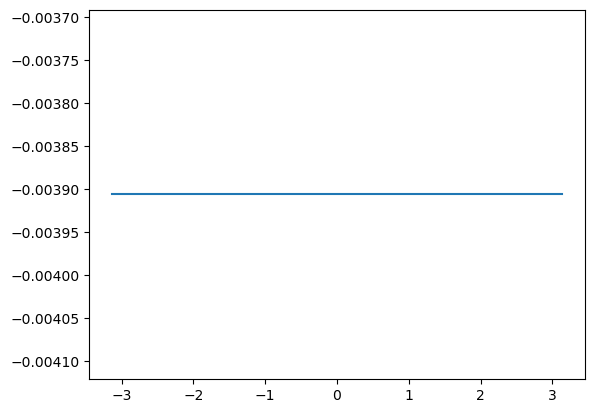

In [533]:
plt.plot(thetarange,mse[-1,:])
plt.show()